<a href="https://colab.research.google.com/github/YeabsiraNigusse/Deep_Learning/blob/main/cat%20image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logistic Regression with a Neural Network mindset

in this note book we will build cat classification using logestic regression

In [68]:
from google.colab import files
upload = files.upload()

Saving my_image.jpg to my_image.jpg


In [28]:
!pip install numpy matplotlib h5py scipy
!pip install Pillow

In [34]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from public_tests import *

In [35]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [36]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images.

y = [1], it's a 'cat' picture.


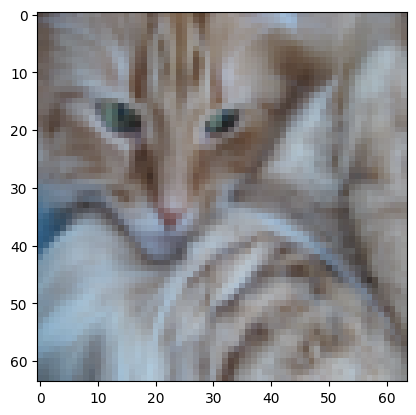

In [39]:
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [41]:
#(≈ 3 lines of code)
# m_train =
# m_test =
# num_px =
# YOUR CODE STARTS HERE
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
# YOUR CODE ENDS HERE

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [42]:
# Reshape the training and test examples
#(≈ 2 lines of code)
# train_set_x_flatten = ...
# test_set_x_flatten = ...
# YOUR CODE STARTS HERE
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# YOUR CODE ENDS HERE

# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [44]:
# Let's standardize our dataset.
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
    
    
**What you need to remember:**
- uploading files and nuccessary libreries
- loading the dataset and visulize it
- figuring out the dimensions and shapes of the data and reshape it

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:

In this exercise, you will carry out the following steps:

    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

<a name='4'></a>
## 4 - Building the parts of our algorithm ##

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.


In [46]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    #(≈ 1 line of code)
    # s = ...
    # YOUR CODE STARTS HERE
    s = 1/(1+np.exp(-z))

    # YOUR CODE ENDS HERE

    return s

In [47]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


In [48]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    # (≈ 2 lines of code)
    # w = ...
    # b = ...
    # YOUR CODE STARTS HERE
    w = np.zeros((dim, 1))
    b = 0.0

    # YOUR CODE ENDS HERE

    return w, b

# we calculate predicted value, cost and gradient for a given training examples

In [49]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    #(≈ 2 lines of code)
    # compute activation
    # A =
    # compute cost by using np.dot to perform multiplication.
    # And don't use loops for the sum.
    # cost = ...
    # YOUR CODE STARTS HERE
    Z = np.dot(w.T, X) + b
    A = 1/(1+np.exp(-Z))
    cost = -1/m*(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))
    # YOUR CODE ENDS HERE

    # BACKWARD PROPAGATION (TO FIND GRAD)
    #(≈ 2 lines of code)
    # dw = ...
    # db = ...
    # YOUR CODE STARTS HERE
    dw = 1/m*(np.dot(X, (A-Y).T))
    db = 1/m*(np.sum(A-Y))
    # YOUR CODE ENDS HERE
    cost = np.squeeze(np.array(cost))


    grads = {"dw": dw,
             "db": db}

    return grads, cost

## we repeat calculating the gradient multiple times and update w and b using the gradient value

In [50]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        # (≈ 1 lines of code)
        # Cost and gradient calculation
        # grads, cost = ...
        # YOUR CODE STARTS HERE
        grads, cost = propagate(w, b, X, Y)

        # YOUR CODE ENDS HERE

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        # w = ...
        # b = ...
        # YOUR CODE STARTS HERE
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # YOUR CODE ENDS HERE

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

### we collect new predicted value with the optimized prameters

In [52]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    #(≈ 1 line of code)
    # A = ...
    # YOUR CODE STARTS HERE
    A = 1 / (1 + np.exp(-(np.dot(w.T, X) + b)))

    # YOUR CODE ENDS HERE

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        #(≈ 4 lines of code)
        # if A[0, i] > ____ :
        #     Y_prediction[0,i] =
        # else:
        #     Y_prediction[0,i] =
        # YOUR CODE STARTS HERE
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0

        # YOUR CODE ENDS HERE

    return Y_prediction

In [53]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    # Initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from the "params" dictionary
    w = params["w"]
    b = params["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("Train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("Test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    # Create a dictionary to store the model's information
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d


In [54]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Train accuracy: 99.04306220095694 %
Test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


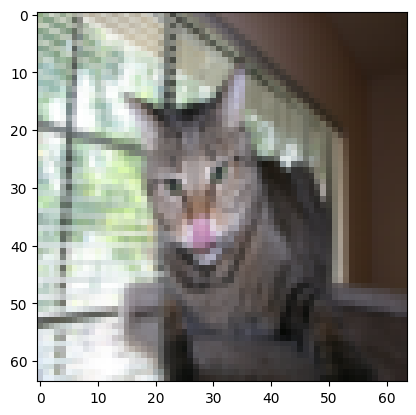

In [57]:
index = 20
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


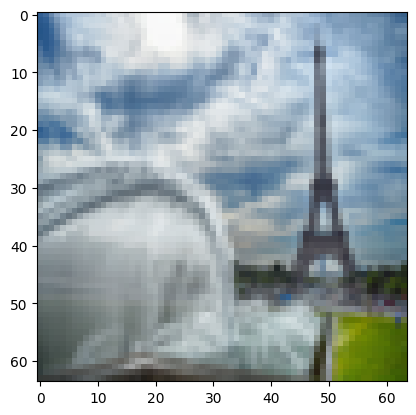

In [69]:
my_image = "my_image.jpg"

# We preprocess the image to fit your algorithm.
fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")